# TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE

- Data source: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation
- Clickable link for the full list of startups in AI medical imagery: https://research.aimultiple.com/looking-for-better-medical-imaging-for-early-diagnostic-and-monitoring-contact-the-leading-vendors-here/

# TASK #2: IMPORT LIBRARIES AND DATASETS

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [ ]:
# You will need to mount your drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Navigate to My Drive directory to store the dataset
%cd /content/drive/MyDrive/Data/AI/AI-Healthcare-Datasets/Brain_MRI


/content/drive/MyDrive/Data/AI/AI-Healthcare-Datasets/Brain_MRI


In [ ]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data_mask.csv')

In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
brain_df[100:200]

,patient_id,image_path,mask_path,mask
100,TCGA_CS_5396_20010302,TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_1.tif,TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_1_...,0
101,TCGA_CS_5396_20010302,TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_1.tif,TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_1_...,0
102,TCGA_CS_5396_20010302,TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif,TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_...,0
103,TCGA_CS_5396_20010302,TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_1.tif,TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_1_...,0
104,TCGA_CS_5396_20010302,TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_1.tif,TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_1_...,0
...,...,...,...,...
195,TCGA_CS_6666_20011109,TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_2.tif,TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_2_...,0
196,TCGA_CS_6666_20011109,TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_2.tif,TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_2_...,0
197,TCGA_CS_6666_20011109,TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_2.tif,TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_2_...,0
198,TCGA_CS_6666_20011109,TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_2.tif,TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_2_...,0


In [ ]:
brain_df.mask_path[1] # Path to the brain MRI image

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [ ]:
brain_df.image_path[1] # Path to the segmentation mask

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

MINI CHALLENGE #1:
  - Do we have a balanced dataset? 
  - How many samples are classified as 'healthy'?

In [ ]:
temp = brain_df[brain_df['mask'] == 1]
temp

brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

# TASK #3: PERFORM DATA VISUALIZATION

In [ ]:
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0
...,...,...,...,...
3924,TCGA_DU_6401_19831001,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...,0
3925,TCGA_DU_6401_19831001,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...,0
3926,TCGA_DU_6401_19831001,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...,0
3927,TCGA_DU_6401_19831001,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...,0


In [ ]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [ ]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

In [ ]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [ ]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

(256, 256, 3)


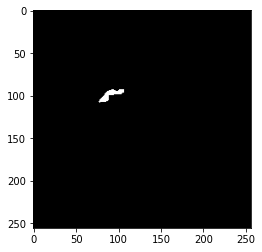

In [ ]:
d = cv2.imread(brain_df.mask_path[623])
print(d.shape)
plt.imshow(d)

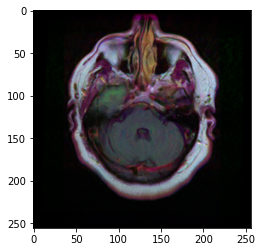

In [ ]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

In [ ]:
cv2.imread(brain_df.mask_path[623]).max()

255

In [ ]:
cv2.imread(brain_df.mask_path[623]).min()

0

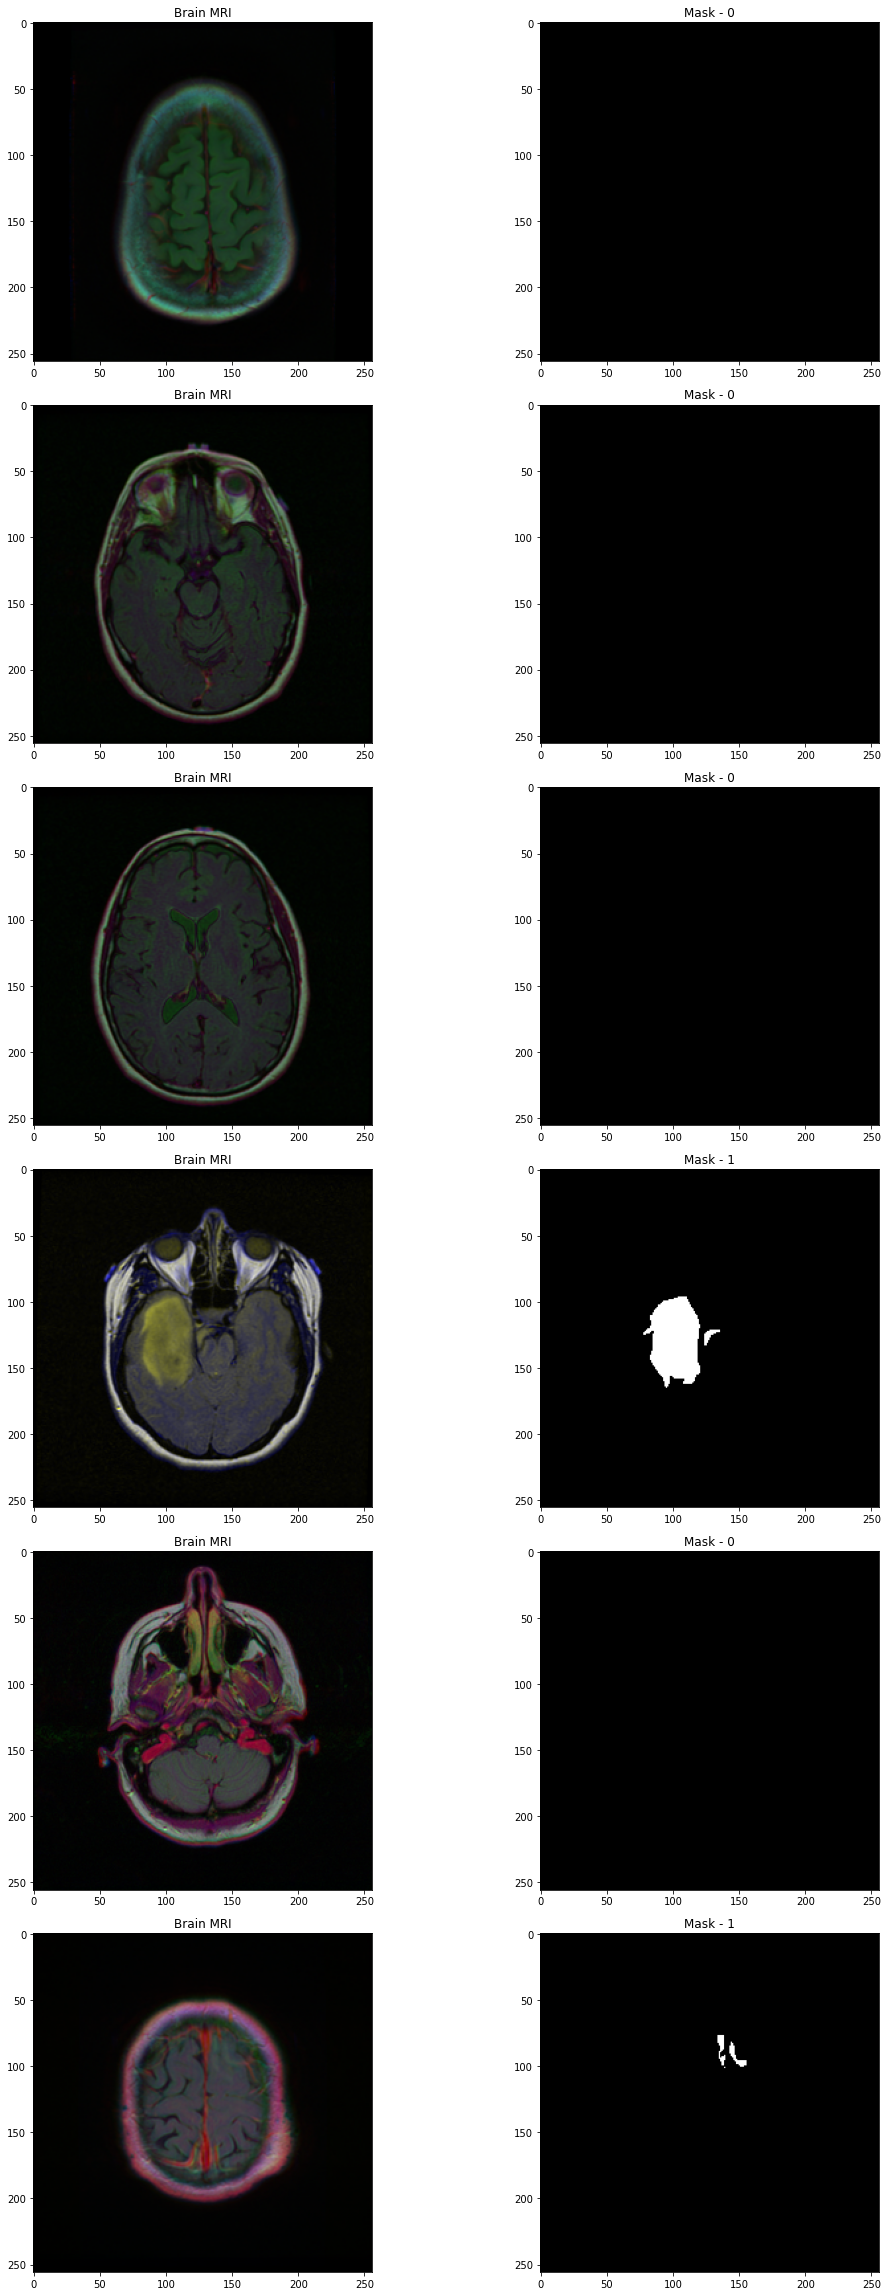

In [ ]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

MINI CHALLENGE #2: 
 - Plot 12 randomly selected (1) MRI scan images from only sick patients followed by (2) corresponding mask, (3) both MRI image and the corresponding mask (in red color) on top of each other

3929


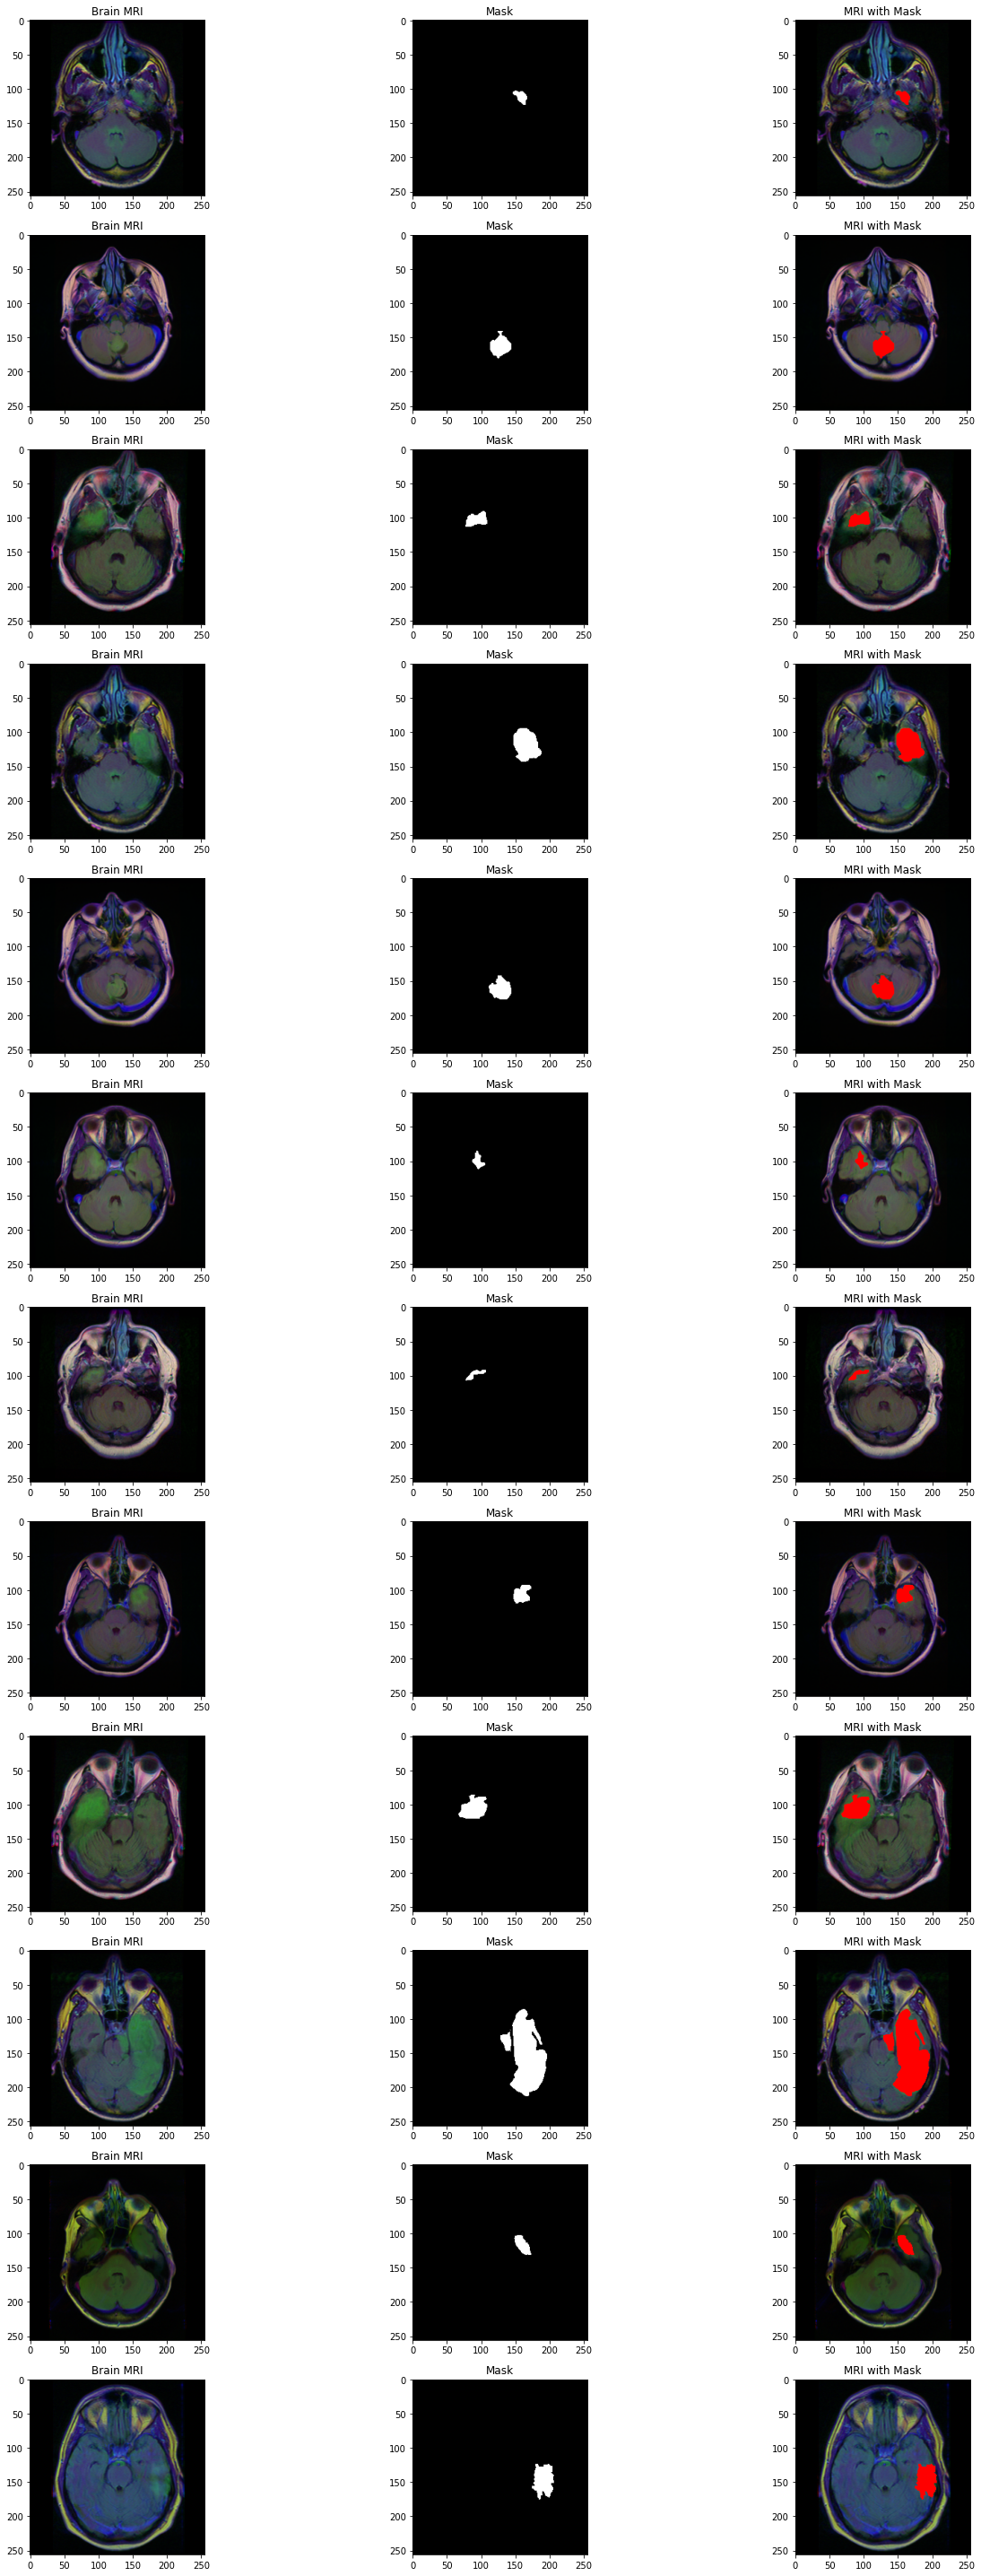

In [ ]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 
import random
fig, axs = plt.subplots(12,3, figsize=(20,40))
count = 0

print(len(brain_df))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
    img = io.imread(brain_df.image_path[i]) 
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    ##where ever mask position is 255 in actual image color it red
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1


fig.tight_layout()

# TASK #4: UNDERSTAND THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS AND RESNETS 

- Feature Extraction and Convolutions: https://setosa.io/ev/image-kernels/
- CNN Visualization: https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html


- Link to ResNet paper entitled (Deep Residual Learning for Image Recognition): https://arxiv.org/pdf/1512.03385.pdf

MINI CHALLENGE #3: 
 - What is the perfomance of ResNet on ImageNet dataset?
 - Explore other CNN architectures such as AlexNet and list their performance compared to ResNet (external research is required)

# TASK #5: UNDERSTAND THE THEORY AND INTUITION BEHIND TRANSFER LEARNING

- Excellent Resource on transfer learning by Dipanjan Sarkar: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
- Article by Jason Brownlee: https://machinelearningmastery.com/transfer-learning-for-deep-learning/

MINI CHALLENGE #4: 
- List the challenges of transfer learning (external research is required)

# TASK #6: TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT

In [ ]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train
#brain_df_train.shape

,image_path,mask_path,mask
0,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0
...,...,...,...
3924,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...,0
3925,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...,0
3926,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...,0
3927,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...,0


In [ ]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if you comment out the following code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)


In [ ]:
# datagen is divided into traing and test generator
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [ ]:
# Get the ResNet50 base model // weight are trained on imagenet dataset, ## include_top do not iclude the dence clasification layer  
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# freeze the model weights
for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# compile the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
##history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

In [ ]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

MINI CHALLENGE #5: 
- Change the network architecture by adding more/less dense layers, neurons or dropout. 
- print out the model summary and compare the total number of trainable parameters between the original and new model

# TASK #7: ASSESS TRAINED MODEL PERFORMANCE

In [ ]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# make prediction
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 136s 4s/step


In [ ]:
test_predict.shape

(576, 2)

In [ ]:
test_predict

array([[1.0000000e+00, 5.1853924e-11],
       [9.9995434e-01, 4.5714052e-05],
       [1.0000000e+00, 1.0698802e-08],
       ...,
       [1.0000000e+00, 1.4311691e-08],
       [9.6551293e-01, 3.4487117e-02],
       [2.1512829e-10, 1.0000000e+00]], dtype=float32)

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

array(['0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0',
       '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '1', '1', '1',
       '0', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0',
       '0', '1', '0', '0', '1', '0', '1', '0', '1', '1', '1', '0', '0',
       '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1',
       '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0',
       '0', '1', '1', '1', '0', '0', '1', '0', '1', '0', '0', '1', '0',
       '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0',
       '0', '0', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9861111111111112

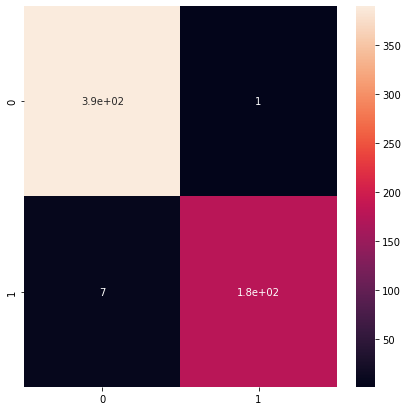

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

MINI CHALLENGE #6: 
- Print out the classification report and comment on the precision, recall and F1-score results

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       391
           1       0.99      0.96      0.98       185

   micro avg       0.99      0.99      0.99       576
   macro avg       0.99      0.98      0.98       576
weighted avg       0.99      0.99      0.99       576



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



# TASK #8: UNDERSTAND THE THEORY AND INTUITION BEHIND RESUNET MODELS

# TASK #9: BUILD A SEGMENTATION MODEL TO LOCALIZE TUMOR

In [ ]:
# Navigate to My Drive directory to store the dataset
%cd /content/drive/MyDrive/Data/AI/Healthcare AI Datasets/Brain_MRI
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data_mask.csv')

[Errno 2] No such file or directory: '/content/drive/MyDrive/Data/AI/Healthcare AI Datasets/Brain_MRI'
/content/drive/MyDrive/Data/AI/AI-Healthcare-Datasets/Brain_MRI


In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask
#brain_df_mask.shape

,patient_id,image_path,mask_path,mask
445,TCGA_DU_5872_19950223,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5_...,1
507,TCGA_DU_5874_19950510,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5_...,1
551,TCGA_DU_5854_19951104,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6_...,1
555,TCGA_DU_5854_19951104,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6_...,1
617,TCGA_DU_5853_19950823,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_...,1
...,...,...,...,...
3785,TCGA_HT_7684_19950816,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_56...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_56...,1
3795,TCGA_HT_7684_19950816,TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_57...,TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_57...,1
3797,TCGA_HT_7684_19950816,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_57...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_57...,1
3806,TCGA_HT_7684_19950816,TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58...,TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58...,1


In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
X_train.image_path

2350    TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_22...
1991    TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_19...
1880    TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_18...
2811    TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_28...
2487    TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_24...
                              ...                        
1763    TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_17...
3388    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_38...
2545    TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_24...
3581    TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_46...
2505    TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_24...
Name: image_path, Length: 1167, dtype: object

In [ ]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path) ## input and output is an image of shape 255.255.3
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
import utilities 
#import DataGenerator

# create image generators

training_generator = utilities.DataGenerator(train_ids,train_mask)
validation_generator = utilities.DataGenerator(val_ids,val_mask)


In [ ]:
training_generator

In [ ]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


MINI CHALLENGE #7: 
- print out the segmentation model summary and list the total number of trainable parameters 

In [ ]:
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                           

# TASK #10: TRAIN A SEGMENTATION RESUNET MODEL TO LOCALIZE TUMOR

## Loss function:
 
We need a custom loss function to train this ResUNet.So,  we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator

import utilities 
#import focal_tversky, tversky_loss, tversky

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = utilities.focal_tversky, metrics = [utilities.tversky])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
#history = model_seg.fit(training_generator, epochs = 1, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

In [ ]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

# TASK #11: ASSESS TRAINED SEGMENTATION RESUNET MODEL PERFORMANCE

In [ ]:
import utilities as utils

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = utils.focal_tversky, metrics = [utils.tversky])

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
import utilities as utils 

# making prediction
image_id, mask, has_mask = utils.prediction(test, model, model_seg)

In [ ]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

,image_path,predicted_mask,has_mask
0,TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_9.tif,No mask,0
1,TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_47...,No mask,0
2,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_71...,No mask,0
3,TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_35...,No mask,0
4,TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_4.tif,No mask,0
...,...,...,...
585,TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_10...,No mask,0
586,TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_43...,"[[[[3.3856747e-06], [5.044748e-06], [6.7641336...",1
587,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_8.tif,No mask,0
588,TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_9.tif,"[[[[6.9080755e-07], [2.439885e-06], [4.3641157...",1


In [ ]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_9.tif,TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_9_...,0,No mask,0
1,TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_47...,TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_47...,0,No mask,0
2,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_71...,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_71...,0,No mask,0
3,TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_35...,TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_35...,0,No mask,0
4,TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_4.tif,TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_4_...,0,No mask,0


In [ ]:
count = 0 
fig, axs = plt.subplots(30, 5, figsize=(30, 100))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 30:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i]) # df_pred now has merged data
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

MINI CHALLENGE:
- Plot 30 images along with their corresponding mask
- Visually verify that model predictions made sense 

# EXCELLENT JOB! NOW YOU KNOW HOW TO APPLY AI TO DETECT AND LOCALIZE BRAIN TUMORS. THIS IS A GREAT ACHIEVEMENT IN HEALTHCARE. 

# MINI CHALLENGE SOLUTIONS

MINI CHALLENGE #3:

- An ensemble of these residual nets achieves 3.57% error
on the ImageNet test set.
- Solution (great article by Siddharth Das): https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5

MINI CHALLENGE #4:
- Negative Transfer occurs when transfer learning negatively affect the model. This occurs when the features of old and new tasks are not related.  
- Transfer bounds: Measuring the amount of knowledge transfered is crucial to ensure model quality and robustness. 